### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

# ### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip3 install -U albumentations>=0.3.0 --user 
# !pip3 install -U --pre segmentation-models --user

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
import keras
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
keras.backend.set_session(tf.Session(config=config))

# Loading dataset

In [6]:
ls /home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/seg/

color_labels/  images/  labels/


In [7]:
path_data = Path('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/seg/')
path_lbl = path_data/'labels'
path_img = path_data/'images'

x_train_dir = path_img/'train'
y_train_dir = path_lbl/'train'

x_valid_dir = path_img/'val'
y_valid_dir = path_lbl/'val'

In [9]:
path_data.

PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/seg')

In [17]:
y_valid_dir

PosixPath('/home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/seg/labels/val')

In [19]:
ls /home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/seg/images/val

7d06fefd-f7be05a6.jpg  8fcce630-3c3e0000.jpg  a2c9376f-00000000.jpg
7d128593-0ccfea4c.jpg  8fcce630-3c3e0001.jpg  a2d1b2be-d0ddcd7d.jpg
7d15b18b-1e0d6e3f.jpg  8fd046f2-2db00000.jpg  a3025d3c-00000000.jpg
7d209219-ccdc1a09.jpg  8fd046f2-93dc0000.jpg  a316282d-0e90097d.jpg
7d22891c-224788c0.jpg  8fd046f2-93dc0001.jpg  a316362b-00000000.jpg
7d2f7975-e0c1c5a7.jpg  8fd046f2-bb680001.jpg  a3258eed-0e021ec9.jpg
7d35e395-ae41f911.jpg  8fd046f2-e41d0000.jpg  a331d08e-7f9c2e5f.jpg
7d4a9094-0455564b.jpg  8fd046f2-e41d0001.jpg  a33b4fd9-f4374799.jpg
7d5040af-1a6f933f.jpg  8fd046f2-ecff0000.jpg  a34fa9b9-f978bc01.jpg
7d6c1119-00000000.jpg  8fdc7513-00000000.jpg  a358d0cc-2eadfb6a.jpg
7d6eb8b3-208131ff.jpg  8ffdafe7-6a45ea3a.jpg  a3829789-00000000.jpg
7d83710e-4697c3b2.jpg  90016677-9ebbc73b.jpg  a3d1d710-59bd8013.jpg
7d89b471-5b76bdb4.jpg  90016677-aab19abe.jpg  a4215cd6-00000000.jpg
7d97d173-09388af3.jpg  90065da2-00000000.jpg  a423019b-960a077f.jpg
7daa6479-67988f3f.jpg  904f9a94-00000000.jpg  a4

In [18]:
ls /home/ruslan/Desktop/Berkeley_DeepDrive/bdd100k/seg/labels/val

7d06fefd-f7be05a6_train_id.png  9a888ffa-96020000_train_id.png
7d128593-0ccfea4c_train_id.png  9a888ffa-96020001_train_id.png
7d15b18b-1e0d6e3f_train_id.png  9a888ffa-c3840000_train_id.png
7d209219-ccdc1a09_train_id.png  9a888ffa-c3840001_train_id.png
7d22891c-224788c0_train_id.png  9a9da7d3-00000000_train_id.png
7d2f7975-e0c1c5a7_train_id.png  9aa07a4e-2a9fdf1b_train_id.png
7d35e395-ae41f911_train_id.png  9aa12a35-79090000_train_id.png
7d4a9094-0455564b_train_id.png  9aa12a35-79090001_train_id.png
7d5040af-1a6f933f_train_id.png  9ac2e84c-3ca039ee_train_id.png
7d6c1119-00000000_train_id.png  9adc5269-00000000_train_id.png
7d6eb8b3-208131ff_train_id.png  9ae4378c-00000000_train_id.png
7d83710e-4697c3b2_train_id.png  9ae74daf-d340f825_train_id.png
7d89b471-5b76bdb4_train_id.png  9aeeef4a-6dfbab1b_train_id.png
7d97d173-09388af3_train_id.png  9af027c1-74ba1b67_train_id.png
7daa6479-67988f3f_train_id.png  9b041468-204c0482_train_id.png
7dc08598-f42e2015_train_id.png  9b0e122c-3eadb465_train

# Dataloader and utility functions 

In [20]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            num_images=-1,
    ):
        self.get_y_fn = lambda x: f'{Path(x).stem}_train_id.png'
        
        self.ids = os.listdir(images_dir)[:num_images]
        self.mask_ids = [self.get_y_fn(iD) for iD in self.ids]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
#         # add background if mask is not binary
#         if mask.shape[-1] != 1:
#             background = 1 - mask.sum(axis=-1, keepdims=True)
#             mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [23]:
mask.shape

(720, 1280, 3)

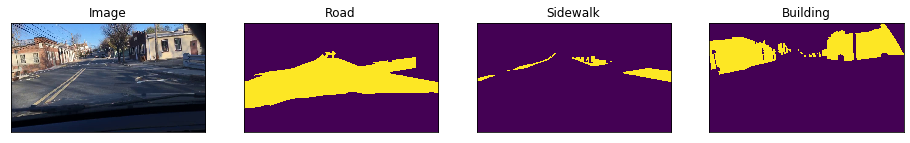

In [25]:
# Lets look at data we have
dataset_raw = Dataset(x_train_dir, y_train_dir, classes=['road', 'sidewalk', 'building'])

image, mask = dataset_raw[0] # get some sample
visualize(
    image=image, 
    road=mask[..., 0].squeeze(),
    sidewalk=mask[..., 1].squeeze(),
    building=mask[..., 2].squeeze(),
)

In [26]:
src_size = np.array(image.shape[:2])
src_size

array([ 720, 1280])

#### Augmentations

In [16]:
mask

array([0., 0., 0.])

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [27]:
import albumentations as A

size = (352, 640) #src_size//2

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.Resize(size[0], size[1], interpolation=1, always_apply=True), #cv2.INTER_LINEAR
        
        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=size[0], min_width=size[1], always_apply=True, border_mode=0),
#         A.RandomCrop(height=size[0], width=size[1], always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(size[0], size[1], interpolation=1, always_apply=True) #cv2.INTER_LINEAR
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [28]:
src_size, size

(array([ 720, 1280]), (352, 640))

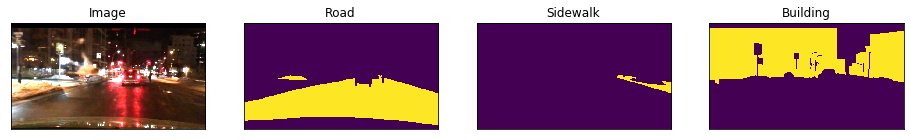

In [30]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['road', 'sidewalk', 'building'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    road=mask[..., 0].squeeze(),
    sidewalk=mask[..., 1].squeeze(),
    building=mask[..., 2].squeeze(),
)

# Segmentation model training

In [31]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [43]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2
CLASSES = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
           'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
           'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void']
LR = 1e-4
EPOCHS = 5

preprocess_input = sm.get_preprocessing(BACKBONE)

In [44]:
# define network parameters
n_classes = len(CLASSES)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

### Class weights for dice loss:

'road': 2.0, 'sidewalk': 1.0, 'building': 0.5, 'wall': 1.0, 'fence': 1.0, 'pole': 0.5, 'traffic light': 2.0,
'traffic sign': 2.0, 'vegetation': 0.5, 'terrain': 0.5, 'sky': 0.5, 'person': 2.0, 'rider': 2.0, 'car': 2.0,
'truck': 2.0, 'bus': 2.0, 'train': 1.0, 'motorcycle': 2.0, 'bicycle': 2.0, 'void': 0.5

In [47]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss(class_weights=np.array([2.0, 1.0, 0.5, 1.0, 1.0, 0.5, 2.0, 2.0,
                                                       0.5, 0.5, 0.5, 2.0,
                                                       2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [48]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    #num_images=200,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    #num_images=100,
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, size[0], size[1], 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, size[0], size[1], n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
MODEL_NAME = 'best_model'

callbacks = [
    keras.callbacks.ModelCheckpoint('./'+MODEL_NAME+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.TensorBoard(log_dir='logs/{}'.format(MODEL_NAME+str(int(time.time()))))
]

/home/ruslan/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [49]:
valid_dataloader[0][0].shape, train_dataloader[0][0].shape

((1, 352, 640, 3), (2, 352, 640, 3))

In [41]:
len(valid_dataloader), len(train_dataloader)

(100, 100)

In [50]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/5
100/100 [==============================] - 76s 759ms/step - loss: 1.1348 - iou_score: 0.2788 - f1-score: 0.2835 - val_loss: 1.0462 - val_iou_score: 0.5499 - val_f1-score: 0.5625

Epoch 2/5
100/100 [==============================] - 54s 540ms/step - loss: 1.0039 - iou_score: 0.4779 - f1-score: 0.4970 - val_loss: 0.8540 - val_iou_score: 0.6110 - val_f1-score: 0.6270
Epoch 3/5
100/100 [==============================] - 55s 555ms/step - loss: 0.9452 - iou_score: 0.5071 - f1-score: 0.5264 - val_loss: 0.8354 - val_iou_score: 0.6234 - val_f1-score: 0.6422
Epoch 4/5
100/100 [==============================] - 56s 556ms/step - loss: 0.9254 - iou_score: 0.5167 - f1-score: 0.5378 - val_loss: 0.8347 - val_iou_score: 0.6276 - val_f1-score: 0.6455
Epoch 5/5
100/100 [==============================] - 54s 544ms/step - loss: 0.9100 - iou_score: 0.5246 - f1-score: 0.5518 - val_loss: 0.8192 - val_iou_score: 0.6558 - val_f1-score: 0.6811


# Model Evaluation

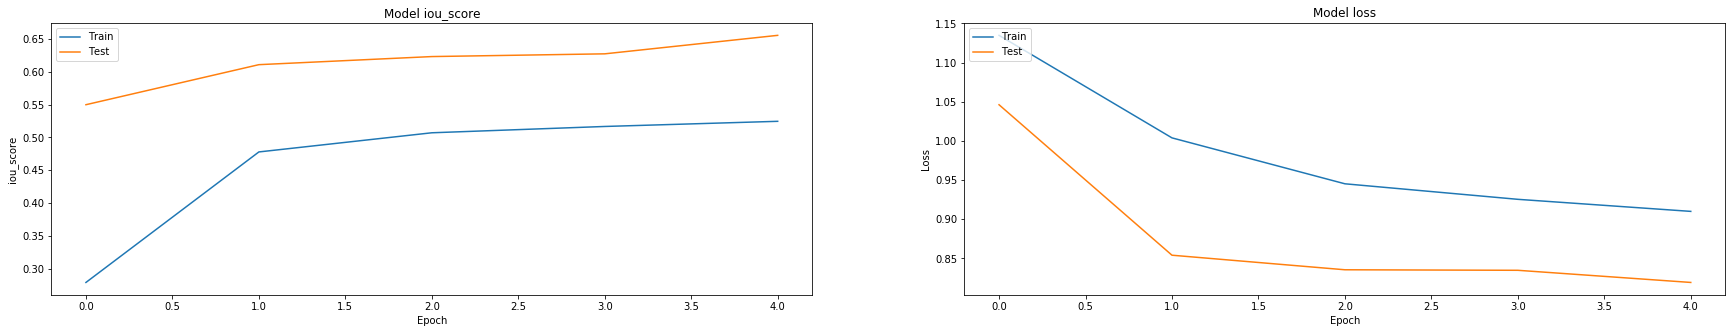

In [51]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
# load best weights
model.load_weights('trained_models/keras/unet-resnet34-drivable-berkeley.h5')

In [21]:
scores = model.evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: -0.000144
mean iou_score: 0.83906
mean f1-score: 0.87461


# Visualization of results on validation dataset

In [75]:
def seglayers2mask(image, output, random_colors=True):
    # infer the total number of classes along with the spatial dimensions
    # of the mask image via the shape of the output array
    (height, width, numClasses) = output.shape[1:4]
    # print("[INFO] Number of classes: {:d}".format(numClasses))

    # our output class ID map will be num_classes x height x width in
    # size, so we take the argmax to find the class label with the
    # largest probability for each and every (x, y)-coordinate in the
    # image
    classMap = np.argmax(output[0], axis=-1)

    # given the class ID map, we can map each of the class IDs to its
    # corresponding color
    if random_colors:
        np.random.seed(0)
        COLORS = np.random.randint(0, 255, size=(numClasses-1, 3), dtype="uint8")
        COLORS = np.vstack([COLORS, [0, 0, 0]]).astype("uint8")
    else:
        COLORS = open('colors.txt').read().strip().split("\n")
        COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
        COLORS = np.array(COLORS, dtype="uint8")
    
    mask = COLORS[classMap]

    # resize the mask and class map such that its dimensions match the
    # original size of the input image (we're not using the class map
    # here for anything else but this is how you would resize it just in
    # case you wanted to extract specific pixels/classes)
    mask = cv2.resize(mask, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_LINEAR)
    # classMap = cv2.resize(classMap, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_NEAREST)

    # perform a weighted combination of the input image with the mask to
    # form an output visualization
    rescaled_image = image[0] - np.min(image[0])
    rescaled_image /= np.max(rescaled_image)
    rescaled_image *= 255 # resaled image has color values in range 0..255
    output = ((0.7 * rescaled_image) + (0.3 * mask)).astype("uint8")
    
    return output

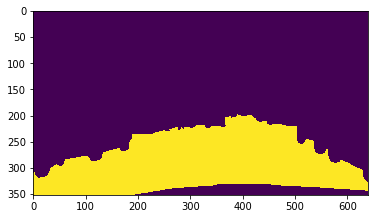

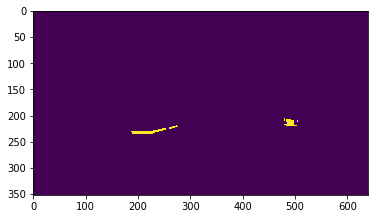

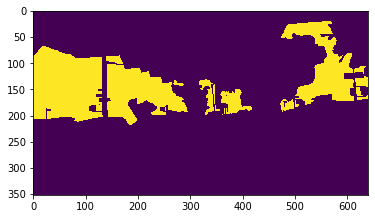

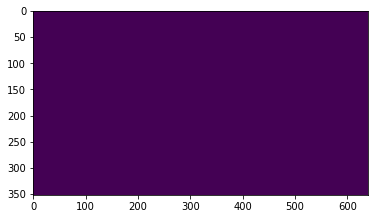

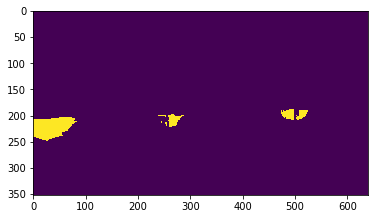

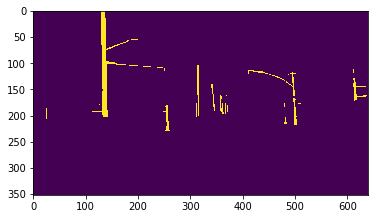

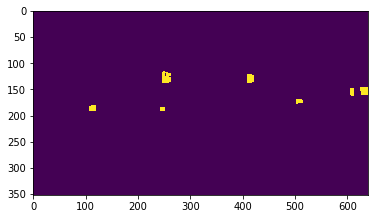

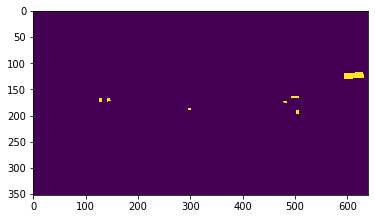

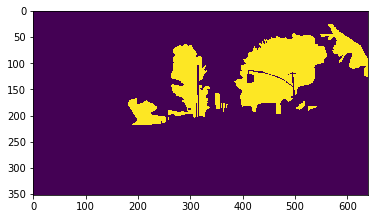

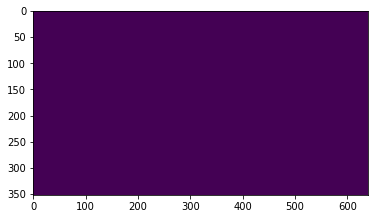

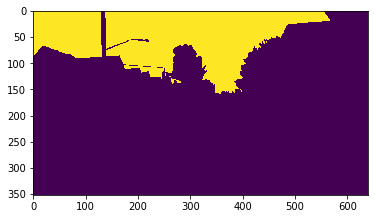

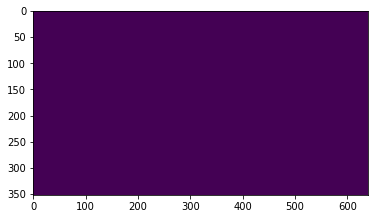

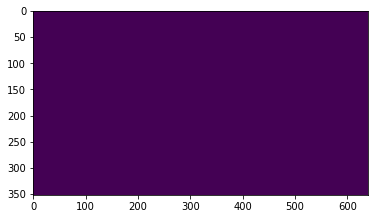

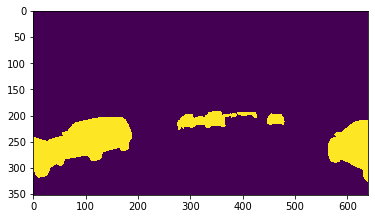

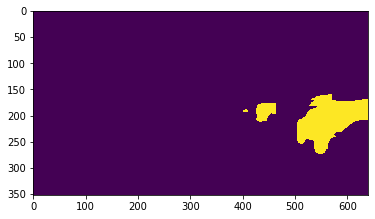

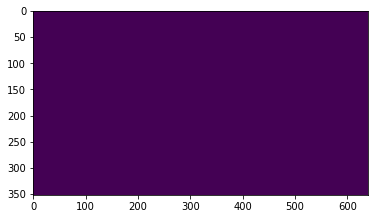

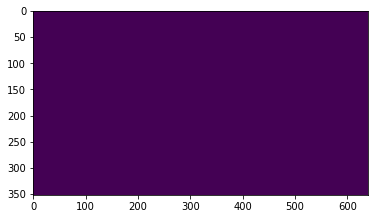

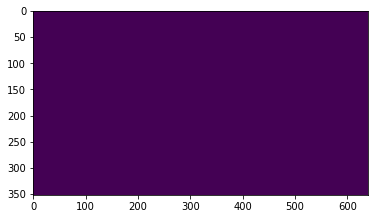

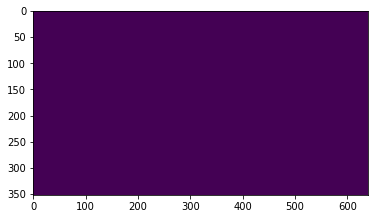

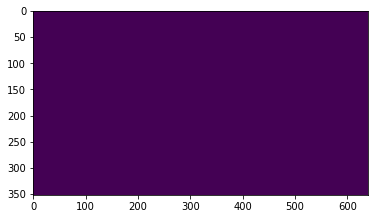

In [65]:
for i in range(20):
    plt.figure()
    plt.imshow(gt_layers[...,i].squeeze())
    plt.show()

Time for forward pass: 0.04057192802429199


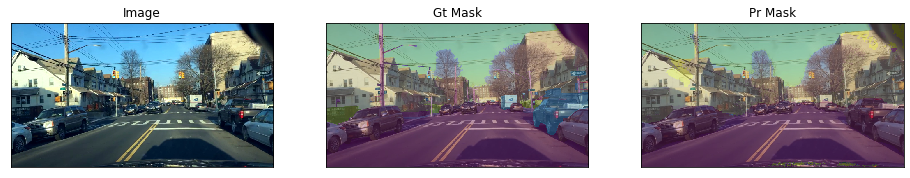

Time for forward pass: 0.044905662536621094


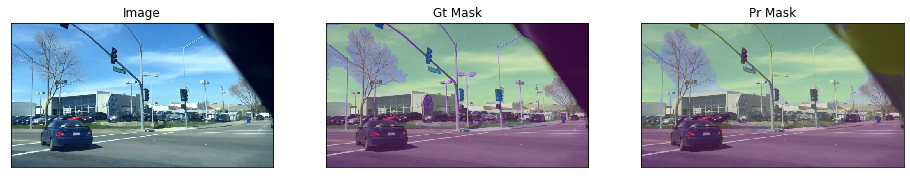

Time for forward pass: 0.04057621955871582


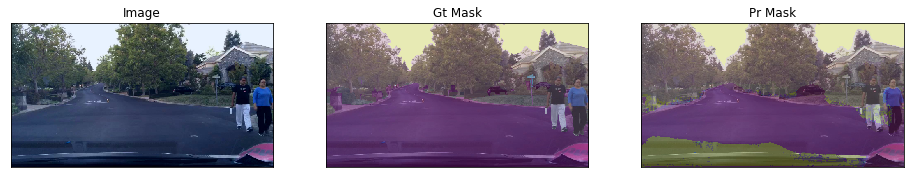

Time for forward pass: 0.04507088661193848


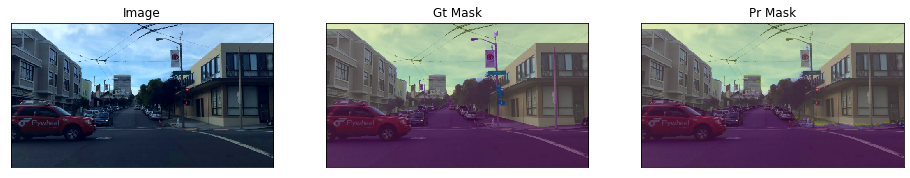

Time for forward pass: 0.04054069519042969


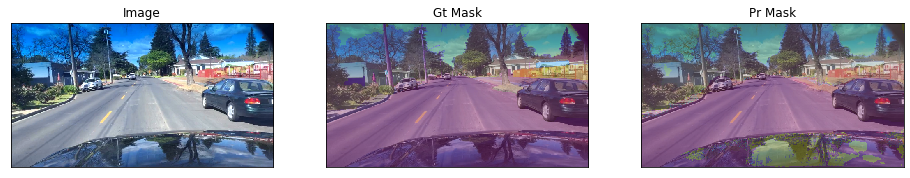

In [76]:
n = 5
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    
    image, gt_layers = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    start = time.time()
    pr_layers = model.predict(image)
    end = time.time()
    print('Time for forward pass:', end-start)
    pr_mask = seglayers2mask(image, pr_layers)
    gt_mask = seglayers2mask(image, np.expand_dims(gt_layers, axis=0))
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask,
        pr_mask=pr_mask,
    )

## Test on video stream

In [102]:
def image_preprocessing(image, size):
    # read data
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # apply preprocessing
    image = cv2.resize(image, size, cv2.INTER_LINEAR)
    image = preprocess_input(image)
    return np.expand_dims(image, axis=0)

In [107]:
import imutils
from tqdm import tqdm

vs = cv2.VideoCapture('/home/ruslan/Desktop/moscow_streets.mp4')
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

FPS = []
# while(1):
for i in tqdm( range(100) ):
    # get raw frames from video stream
    ret, frame_raw = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    start = time.time()
    frame = image_preprocessing(frame_raw, (size[1], size[0]))
    # predict segmentation mask from the frame
    pr_layers = model.predict(frame)
    end = time.time()
    dt = end-start
    FPS.append(1./dt)
    pr_mask = seglayers2mask(frame, pr_layers)
#     print("[INFO] single frame took {:.4f} seconds".format(dt))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('moscow_semantic_segmentation_berkeley_keras.avi', fourcc, 30,
            (pr_mask.shape[1], pr_mask.shape[0]), True)

        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time: {:.4f} [min]".format(elap * total/60.))

    # write the output frame to disk
#     writer.write(pr_mask)
print("[INFO] Mean FPS {:.4f} Hz".format(np.mean(FPS)))
#     visualize(
#         image=denormalize(frame.squeeze()),
#         pr_mask=pr_mask,
#     )

  2%|▏         | 2/100 [00:00<00:05, 19.45it/s]

[INFO] 12911 total frames in video
[INFO] single frame took 0.0423 seconds
[INFO] estimated total time: 9.0960 [min]


100%|██████████| 100/100 [00:04<00:00, 21.79it/s]

[INFO] Mean FPS 26.4875 Hz


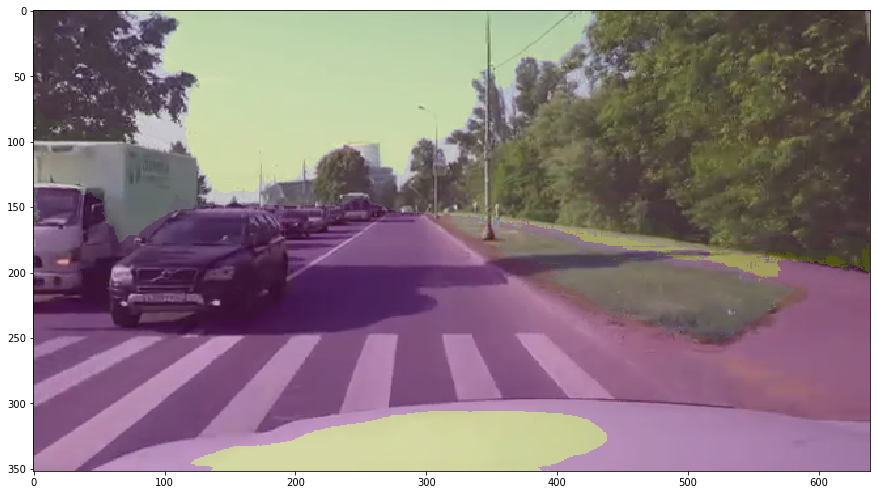

In [108]:
plt.figure(figsize=(15,10))
plt.imshow(pr_mask);